In [ ]:
import os
import cv2
import  numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
#  dataset
base_path = path  # This already points to something like '/kaggle/input/chest-xray-pneumonia/chest_xray'
base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
categories = ['PNEUMONIA', 'NORMAL']  # Use actual folder names
phases = ['train', 'val', 'test']

In [ ]:
print("Subdirectories inside train folder:", os.listdir(os.path.join(base_path, 'train')))


Subdirectories inside train folder: ['PNEUMONIA', 'NORMAL']


In [ ]:
# Display sample images function
def display_samples(base_path, phase, category, n=3):
    folder_path = os.path.join(base_path, phase, category)
    if not os.path.exists(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return

    files_list = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    files = files_list[:n]

    if not files:
        print(f"No image files found in {folder_path}")
        return

    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{category} Sample {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Sample images from the dataset:


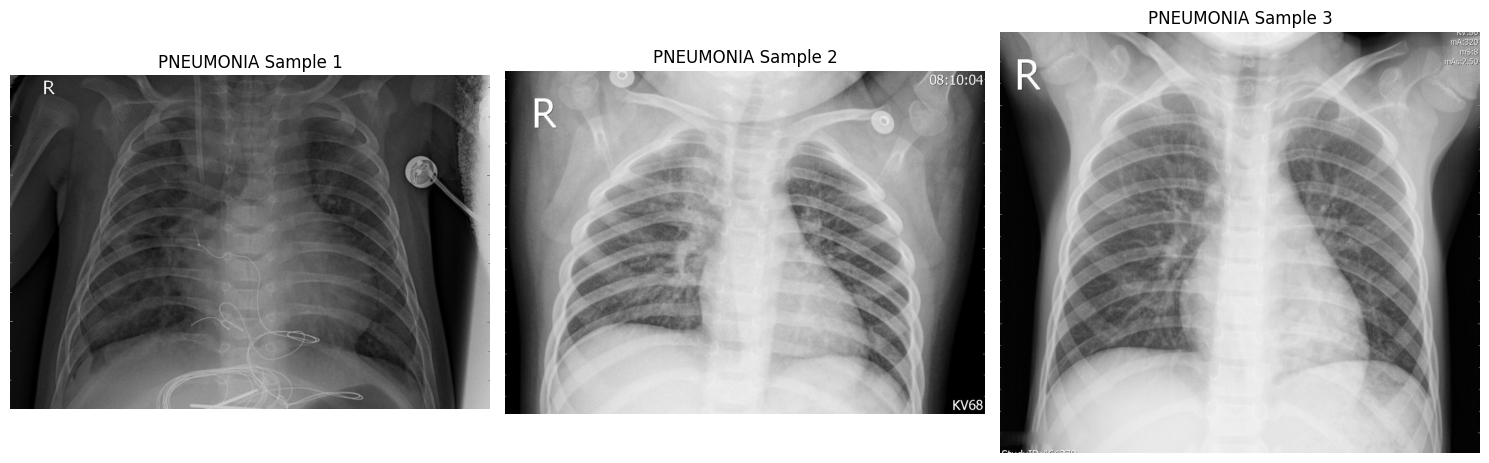

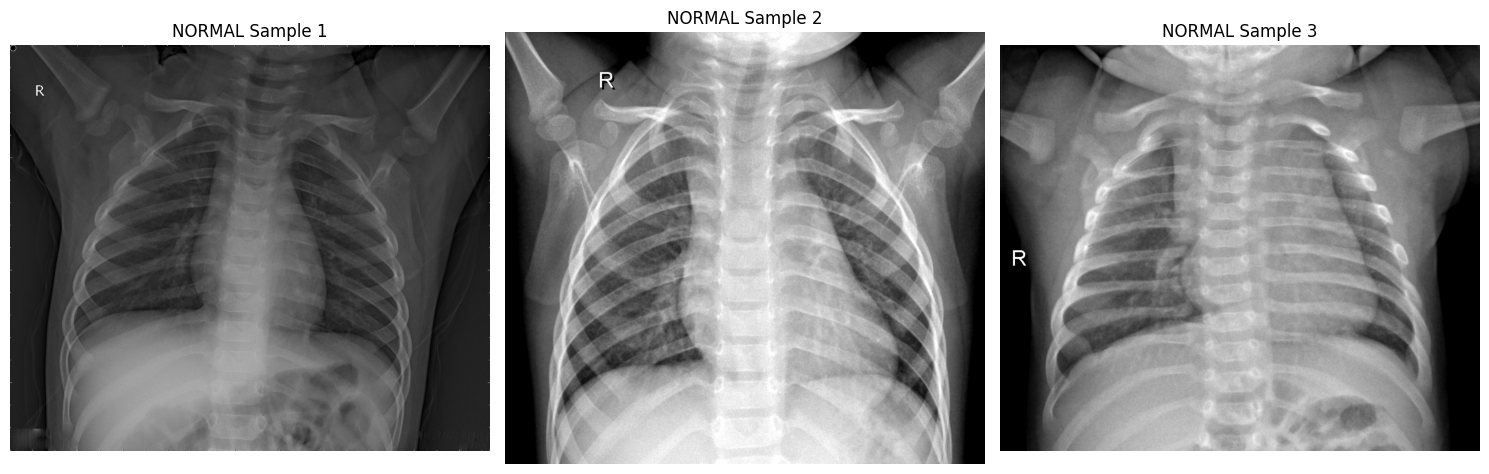

In [ ]:
# Display samples from both categories
print("Sample images from the dataset:")
display_samples(base_path, 'train', 'PNEUMONIA', n=3)
display_samples(base_path, 'train', 'NORMAL', n=3)

In [ ]:
#  Sharpen filter
#  Remove unwanted details
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

In [ ]:
def show_image(title, image):
  plt.imshow(image, cmap='gray')
  plt.title(title)
  plt.axis('off')
  plt.show()


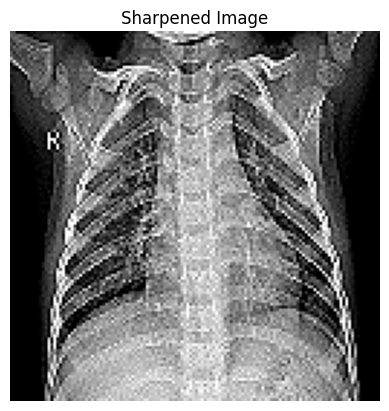

In [ ]:
img_path = os.path.join(base_path, 'train', 'NORMAL', 'IM-0125-0001.jpeg')# Read and resize
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply sharpen_image
sharpened = sharpen_image(gray)
show_image('Sharpened Image', sharpened)


In [ ]:
#  Simple segmentation by thresholding
#  Neglecting the background
def simple_segmentation(img):
    _, mask = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    return cv2.bitwise_and(img, img, mask=mask)

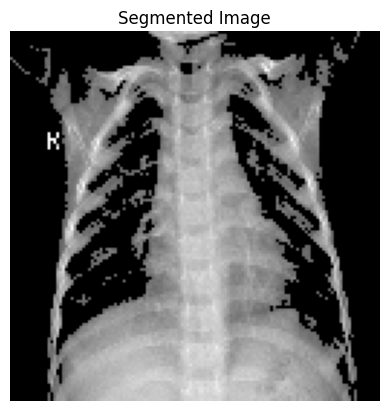

In [ ]:
# Apply simple_segmentation
segmented = simple_segmentation(gray)
show_image('Segmented Image', segmented)

In [ ]:
#  Feature extraction using HOG
def extract_hog_features(img):
    winSize = (128, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    return hog.compute(img).flatten()


In [ ]:
def enhanced_process_image(img_path):
    # Load the image
    img = cv2.imread(img_path)

    # Resize to a consistent size (larger for better feature capture)
    img = cv2.resize(img, (256, 256))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Denoising (median filter to reduce noise while preserving edges)
    gray = cv2.medianBlur(gray, 3)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Gamma correction (to enhance local contrast)
    gamma = 1.2
    look_up_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
    gray = cv2.LUT(gray, look_up_table)

    # Sharpening (stronger kernel for medical clarity)
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    gray = cv2.filter2D(gray, -1, sharpen_kernel)

    # Threshold segmentation (optional)
    _, mask = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    gray = cv2.bitwise_and(gray, gray, mask=mask)

    # Normalize (standard scaling to [0, 1] range)
    gray = gray.astype(np.float32) / 255.0

    # Resize to HOG compatible size
    gray = cv2.resize(gray, (128, 128))

    # Convert to uint8 again for HOG
    gray = (gray * 255).astype(np.uint8)

    # Extract HOG features
    features = extract_hog_features(gray)

    return features, gray


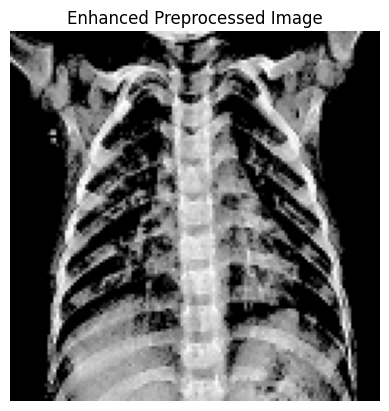

Enhanced HOG Features shape: (8100,)
First 10 HOG values: [0.06706796 0.09524389 0.08230843 0.07306325 0.13277479 0.26127034
 0.26127034 0.18074502 0.05662862 0.07324357]


In [ ]:
features, enhanced_img = enhanced_process_image(img_path)
show_image('Enhanced Preprocessed Image', enhanced_img)

print(f'Enhanced HOG Features shape: {features.shape}')
print(f'First 10 HOG values: {features[:10]}')


In [ ]:
## 3. Dataset Loader
def load_images_from_folder(folder, img_size=(128, 128)):
    data, labels = [], []
    classes = os.listdir(folder)
    for label in classes:
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            img = imread(os.path.join(label_folder, filename))
            img = resize(rgb2gray(img), img_size)
            data.append(img)
            labels.append(0 if label == 'NORMAL' else 1)
    return np.array(data), np.array(labels)

In [ ]:
# Feature Extraction
def extract_features(images):
    return np.array([extract_hog_features(image) for image in images])

In [ ]:
hog_features = enhanced_process_image(img_path)

In [ ]:
# hog_features, _ = enhanced_process_image(img_path)  # Only keep features
# X_test.append(hog_features)


In [ ]:
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix ,f1_score

from sklearn.model_selection import cross_val_predict

In [ ]:
# Collect features and labels
X_train, Y_train = [], []
X_val, Y_val = [], []
X_test, Y_test = [], []

for phase in phases:
    for label, category in enumerate(categories):
        folder_path = os.path.join(base_path, phase, category)
        files = os.listdir(folder_path)
        for img_file in files:
            img_path = os.path.join(folder_path, img_file)
            features, _ = enhanced_process_image(img_path)  # discard image
            if phase == 'train':
                X_train.append(features)
                Y_train.append(label)
            elif phase == 'val':
                X_val.append(features)
                Y_val.append(label)
            else:
                X_test.append(features)
                Y_test.append(label)



X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
# Combine training and validation sets
X_combined = np.vstack([X_train, X_val])
y_combined = np.hstack([Y_train, Y_val])

In [ ]:
# Ensure labels are binary {0, 1}
y_combined = (y_combined == 1).astype(int)
Y_test = (Y_test == 1).astype(int)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Reduce number of features to 1000 using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=1000)
X_combined_reduced = selector.fit_transform(X_combined_scaled, y_combined)
X_test_reduced = selector.transform(X_test_scaled)


In [ ]:
from sklearn.model_selection import train_test_split

# Use only 20% of samples for the genetic algorithm
X_ga, _, y_ga, _ = train_test_split(
    X_combined_reduced, y_combined, test_size=0.8, stratify=y_combined, random_state=42
)


In [ ]:
# Get feature count
num_features = X_combined_reduced.shape[1]

In [ ]:
print(num_features)

1000


In [ ]:
# Final shapes (optional print for debugging)
print(f"Train+Val samples: {X_ga.shape}, Test samples: {X_test_reduced.shape}")
print(f"Number of features: {num_features}")

Train+Val samples: (1046, 1000), Test samples: (624, 1000)
Number of features: 1000


In [ ]:
# === STEP 2: Pre Feature Selection Evaluation ===

knn_pre = KNeighborsClassifier(n_neighbors=5)

# Use full feature set before selection
cv_scores_pre = cross_val_score(knn_pre, X_combined_reduced, y_combined, cv=5)
pre_cv_accuracy = np.mean(cv_scores_pre)
pre_cv_std = np.std(cv_scores_pre)

# Cross-validation predictions
y_pred_pre = cross_val_predict(knn_pre, X_combined_reduced, y_combined, cv=5)
pre_classification_report = classification_report(y_combined, y_pred_pre)
pre_confusion_matrix = confusion_matrix(y_combined, y_pred_pre)

print(f"Before Feature Selection:")
print(f"  Average Accuracy: {pre_cv_accuracy:.4f}")
print(f"  Accuracy Std Dev: {pre_cv_std:.4f}")
print("[Pre] Classification Report:\n", pre_classification_report)
print("[Pre] Confusion Matrix:\n", pre_confusion_matrix)
print(f"[Pre] Number of Features Used: {X_combined_reduced.shape[1]}")

Before Feature Selection:
  Average Accuracy: 0.9434
  Accuracy Std Dev: 0.0047
[Pre] Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      3883
           1       0.84      0.96      0.90      1349

    accuracy                           0.94      5232
   macro avg       0.91      0.95      0.93      5232
weighted avg       0.95      0.94      0.94      5232

[Pre] Confusion Matrix:
 [[3646  237]
 [  59 1290]]
[Pre] Number of Features Used: 1000


In [ ]:
print("=== Dataset Information ===")
print(f"Training Samples: {X_train.shape[0]}, Validation Samples: {X_val.shape[0]}")
print(f"Total Samples (after concatenation): {X_ga.shape[0]}")
print(f"Number of Features: {num_features}")

print("\n=== Label Distribution ===")
unique, counts = np.unique(y_combined, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

print("\n=== Feature Statistics (after scaling) ===")
print(f"Mean of features: {np.mean(X_ga):.4f}")
print(f"Std of features: {np.std(X_ga):.4f}")

=== Dataset Information ===
Training Samples: 5216, Validation Samples: 16
Total Samples (after concatenation): 1046
Number of Features: 1000

=== Label Distribution ===
Label 0: 3883 samples
Label 1: 1349 samples

=== Feature Statistics (after scaling) ===
Mean of features: 0.0057
Std of features: 0.9976


In [ ]:
""""
# Logistic Regression Evaluation
def logistic_reg(X_sel, y):
    X_train, X_test, y_train_, y_test_ = train_test_split(X_sel, y, test_size=0.3, random_state=42)

    model = LogisticRegression(max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train_)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test_, y_pred)
    cm = confusion_matrix(y_test_, y_pred)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    return f1, specificity
"""
# K-Nearest Neighbors Evaluation
def knn(X_sel, y, k=5):
    X_train, X_test, y_train_, y_test_ = train_test_split(X_sel, y, test_size=0.3, random_state=42)

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train_)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test_, y_pred)
    cm = confusion_matrix(y_test_, y_pred)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

    return f1, specificity
"""
# Random Forest Evaluation (only Accuracy)
def random_forest(X_sel, y):
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    scores = cross_val_score(model, X_sel, y, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean(), 0  # Accuracy only
"""

"\n# Random Forest Evaluation (only Accuracy)\ndef random_forest(X_sel, y):\n    model = RandomForestClassifier(n_estimators=50, random_state=42)\n    scores = cross_val_score(model, X_sel, y, cv=5, scoring='accuracy', n_jobs=-1)\n    return scores.mean(), 0  # Accuracy only\n"

In [ ]:
#f1_log, spec_log = logistic_reg(X_combined_scaled, y_combined)
f1_knn, spec_knn = knn(X_combined_scaled, y_combined)
#acc_rf, _ = random_forest(X_combined_scaled, y_combined)

#print(f"Logistic Regression - F1: {f1_log:.4f}, Specificity: {spec_log:.4f}")
print(f"KNN - F1: {f1_knn:.4f}, Specificity: {spec_knn:.4f}")
#print(f"Random Forest - Accuracy: {acc_rf:.4f}")

KNN - F1: 0.8772, Specificity: 0.9127


In [ ]:
"""
Explanation of Components
np.random.randint(0, 2, size=(population_size, num_features)):

This generates a 2D NumPy array.

Each element in the array is randomly chosen from the set {0, 1}.

num_features is the number of genes (columns) per individual.
"""

# Initialize population
def initialize_population():
    return np.random.randint(0, 2, size=(population_size, num_features))

# Binary representation

"""
def smart_initialize_population():
    population = []
    try:
        # Try loading saved elites
        with open('saved_elites.txt', 'r') as f:
            for line in f:
                individual = np.array(list(map(int, line.strip().split())))
                population.append(individual)
    except FileNotFoundError:
        pass  # First run: no saved elites yet

    # Fill the rest of the population randomly
    while len(population) < population_size:
        individual = np.random.randint(2, size=num_features)
        population.append(individual)

    return np.array(population)
"""

"\ndef smart_initialize_population():\n    population = []\n    try:\n        # Try loading saved elites\n        with open('saved_elites.txt', 'r') as f:\n            for line in f:\n                individual = np.array(list(map(int, line.strip().split())))\n                population.append(individual)\n    except FileNotFoundError:\n        pass  # First run: no saved elites yet\n\n    # Fill the rest of the population randomly\n    while len(population) < population_size:\n        individual = np.random.randint(2, size=num_features)\n        population.append(individual)\n\n    return np.array(population)\n"

In [ ]:
# Fitness function: combine accuracy and number of features used
Alpha = 2500
Beta = 2500
Gamma = 5000


def fitness(individual):
    if np.count_nonzero(individual) == 0:
        return 0  # prevent selecting no features

    selected_indices = np.where(individual == 1)[0] #Get the indices of the features that are selected (those with value 1).

    # Check if any features are selected
    if len(selected_indices) == 0:
        return 0  # Return 0 fitness if no features are selected

    X_sel = X_ga[:, selected_indices] #Create a new feature matrix X_sel using only the selected features (columns) from X.

    f1 ,specificity = chosen_model(X_sel,y_ga)

    reduction = 1.0 - (np.count_nonzero(individual) / len(individual)) #This gives a value between 0 and 1, where 1 means all features are removed (ideal for simplicity), and 0 means none were removed.

    return Alpha * f1 + Beta * specificity  + Gamma * reduction

In [ ]:
#pop: the population (array of individuals).
#fits: the corresponding fitness scores for each individual.


# Selection: Tournament selection
def tournament_selection(pop, fits):

    idx = np.random.choice(len(pop), 2, replace=False) #Randomly select two distinct individuals from the population using their indices.

    return pop[idx[0]] if fits[idx[0]] > fits[idx[1]] else pop[idx[1]]
     #Compare their fitness scores.
     #Return the one with the higher fitness.



#Selection: Rank Selection
def rank_selection(pop, fits):
    ranked_population = sorted(zip(pop, fits), key=lambda x: x[1], reverse=True)
    total_rank = sum(range(1, len(pop) + 1))
    selection_probs = [rank / total_rank for rank in range(1, len(pop) + 1)]
    selected_idx = np.random.choice(len(pop), p=selection_probs)
    return ranked_population[selected_idx][0]



#Selection: Roullette wheel selection
def roulette_wheel_selection(pop, fits):
    total_fitness = np.sum(fits)
    selection_probs = fits / total_fitness
    selected_idx = np.random.choice(len(pop), p=selection_probs)
    return pop[selected_idx]

In [ ]:
# Crossover: single point
def single_point_crossover(parent1, parent2):

    point = np.random.randint(1, num_features) #Choose a random crossover point, somewhere between 1 and (num_features - 1).


    child1 = np.concatenate([parent1[:point], parent2[point:]]) #child1 gets the first part of parent1 and the second part of parent2.


    child2 = np.concatenate([parent2[:point], parent1[point:]])#child2 with the opposite.

    return child1, child2


# Crossover: Two-point Crossover
def two_point_crossover(parent1, parent2):
    point1 = np.random.randint(1, num_features - 1)
    point2 = np.random.randint(point1, num_features)
    child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
    child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])
    return child1, child2


# Crossover: N-point Crossover
def n_point_crossover(parent1, parent2, n_points=3):
    # Ensure valid number of crossover points
    if n_points >= len(parent1):
        raise ValueError("Number of crossover points must be less than the length of the individual.")

    # Randomly choose sorted unique crossover points
    points = sorted(np.random.choice(range(1, len(parent1)), n_points, replace=False))
    points = [0] + points + [len(parent1)]

    child1 = []
    child2 = []

    for i in range(len(points) - 1):
        start, end = points[i], points[i + 1]
        if i % 2 == 0:
            child1.extend(parent1[start:end])
            child2.extend(parent2[start:end])
        else:
            child1.extend(parent2[start:end])
            child2.extend(parent1[start:end])

    return np.array(child1), np.array(child2)


# Crossover: Uniform Crossover
def uniform_crossover(parent1, parent2):
    mask = np.random.randint(2, size=num_features)
    child1 = np.where(mask == 1, parent1, parent2)
    child2 = np.where(mask == 0, parent1, parent2)
    return child1, child2

In [ ]:
# Mutation: flip bits with some probability
def bit_filp_mutation(individual,mutation_rate = 0.05):

    for i in range(num_features):

        if np.random.rand() < mutation_rate:# If the random number is less than mutation_rate.

            individual[i] = 1 - individual[i]#We flip the bit.

    return individual



def random_resetting_mutation(individual, mutation_rate=0.05):

    for i in range(num_features):

        if np.random.rand() < mutation_rate:
            individual[i] = np.random.randint(2)  # randomly 0 or 1

    return individual


def multiple_bit_mutation(individual,mutation_rate ,num_bits_to_flip=max(1, int(0.0001 * num_features))):
    indices = np.random.choice(num_features, size=num_bits_to_flip, replace=False)
    for idx in indices:
        individual[idx] = 1 - individual[idx]
    return individual


In [ ]:
# Strategies
models = [knn]
mutations = [bit_filp_mutation, random_resetting_mutation, multiple_bit_mutation]
selections = [tournament_selection, rank_selection, roulette_wheel_selection]
crossovers = [single_point_crossover, two_point_crossover, n_point_crossover, uniform_crossover]

In [ ]:
def choose_option(options, name):
    print(f"\nChoose a {name}:")
    for idx, option in enumerate(options):
        print(f"{idx + 1}. {option.__name__}")

    while True:
        try:
            choice = int(input(f"Enter the number of the {name} you want: ")) - 1
            if 0 <= choice < len(options):
                return options[choice]
            else:
                print("Invalid choice. Try again.")
        except ValueError:
            print("Please enter a valid number.")

# Menu interaction
chosen_model = choose_option(models, "model")
chosen_mutation = choose_option(mutations, "mutation strategy")
chosen_selection = choose_option(selections, "selection strategy")
chosen_crossover = choose_option(crossovers, "crossover method")

print("\n✅ Your choices:")
#print(f"Model: {chosen_model.__name__}")
print(f"Mutation: {chosen_mutation.__name__}")
print(f"Selection: {chosen_selection.__name__}")
print(f"Crossover: {chosen_crossover.__name__}")



Choose a model:
1. knn
Enter the number of the model you want: 1

Choose a mutation strategy:
1. bit_filp_mutation
2. random_resetting_mutation
3. multiple_bit_mutation
Enter the number of the mutation strategy you want: 2

Choose a selection strategy:
1. tournament_selection
2. rank_selection
3. roulette_wheel_selection
Enter the number of the selection strategy you want: 1

Choose a crossover method:
1. single_point_crossover
2. two_point_crossover
3. n_point_crossover
4. uniform_crossover
Enter the number of the crossover method you want: 4

✅ Your choices:
Mutation: random_resetting_mutation
Selection: tournament_selection
Crossover: uniform_crossover


In [ ]:
print(f"Mutation: {chosen_mutation.__name__}")
print(f"Selection: {chosen_selection.__name__}")
print(f"Crossover: {chosen_crossover.__name__}")

# GA parameters
population_size = 150
num_generations = 125
mutation_rate = 0.08
early_stopping_rounds = 15  # no improvement limit

# Main function
if __name__ == "__main__":

  for run in range(1):  # 30 runs
      print("Run: ", run+1)
      seed = 48 + run
      random.seed(seed)
      np.random.seed(seed)
      print(f"Random seed: {seed}")

      # Initialize variables
      population = initialize_population()
      best_fitness = -np.inf
      stagnation = 0

      # --- Simulated Annealing-like decay ---
      initial_mutation_rate = mutation_rate * 3.0  # Start with a high rate
      decay_rate = 0.03  # Decay constant, tune as needed

      mutation_base_rate = initial_mutation_rate
      mutation_boost_rate = 1.0
      boosted = False
      mutation_decrease_rate = 0.02
      stagnation_threshold_for_boost = 5
      crossover_rate = 0.8

      # Tracking for plots (optional)
      fitness_history = []  # Commented out for plotting
      diversity_history = []  # Commented out for plotting
      population_fitness_history = []  # Commented out for plotting
      mutation_effectiveness_improvements = 0  # Commented out for plotting
      mutation_effectiveness_worsens = 0  # Commented out for plotting
      feature_selection_counts = np.zeros(num_features)  # Commented out for plotting
      global_elites = []  # Commented out for plotting

      # Core GA Loop
      for generation in range(num_generations):

          # --- Annealing: exponential decay of mutation rate ---
          if not boosted:
              mutation_base_rate = max(mutation_rate, initial_mutation_rate * np.exp(-decay_rate * generation))


          # Evaluate fitness
          fitnesses = [fitness(ind) for ind in population]


          # ----------- Elitism ------------
          top_k = max(1, int(0.07 * len(population)))
          elites_idx = np.argsort(fitnesses)[-top_k:]
          elites = [population[i].copy() for i in elites_idx]
          global_elites.extend(elites)
          global_elites = sorted(global_elites, key=fitness, reverse=True)[:int(
             0.1 * population_size * num_generations)]
          new_population = elites.copy()


          # ----------- Logging ------------
          best_idx = elites_idx[-1]
          current_best_fitness = fitnesses[best_idx]
          current_best_individual = population[best_idx].copy()

          print(
              f"Generation {generation + 1}: Best Fitness = {current_best_fitness:.4f}, Mutation Rate = {mutation_base_rate:.6f}, Features Selected: {np.sum(current_best_individual):d} out of {num_features}"
          )


          # ----------- Stagnation Handling ------------
          if current_best_fitness > best_fitness:
              best_fitness = current_best_fitness
              overall_best_individual = current_best_individual.copy()
              stagnation = 0

          # Decay boosted rate if still boosted
          elif boosted:
              mutation_base_rate = max(
                  mutation_rate, mutation_base_rate - mutation_decrease_rate) #example max(0.08, 0.24 - 0.02)
              if mutation_base_rate <= mutation_rate:
                  boosted = False

          else:
              stagnation += 1
              if stagnation >= early_stopping_rounds:
                  print("Early stopping due to no improvement.")
                  break


          if stagnation > stagnation_threshold_for_boost and not boosted: #stagnation > 5
              print("Stagnation detected. Temporarily boosting mutation rate.")
              mutation_base_rate = initial_mutation_rate * mutation_boost_rate
              boosted = True
            # stagnation = 0  # Reset stagnation counter


          # ----------- Logging (continued) -----------
          # Record best fitness for plotting
          fitness_history.append(current_best_fitness)  # Commented out for plotting
          population_fitness_history.append(fitnesses)  # Commented out for plotting


          # ----------- Diversity Tracking (optional) ------------
          unique_individuals = len(set(tuple(ind) for ind in population))  # Commented out for plotting
          diversity_history.append(unique_individuals / population_size)  # Commented out for plotting


          # ----------- Selection and Crossover ------------
          for _ in range(population_size - len(elites)):
              parent1 = chosen_selection(population, fitnesses)
              parent2 = chosen_selection(population, fitnesses)

              if np.random.rand() < crossover_rate: # random < 0.8
                  child1, child2 = chosen_crossover(parent1, parent2)
                  new_population.extend([child1, child2])
              else:
                  new_population.extend([parent1.copy(), parent2.copy()])


          # Trim or pad the population to maintain population_size
          new_population = new_population[:population_size]
          population = new_population


          if generation < num_generations - 1:
            # Apply mutation
            for i in range(len(population)):
                original_fitness = fitness(population[i])
                mutated_individual = chosen_mutation(
                    population[i].copy(), mutation_base_rate)

            mutated_fitness = fitness(mutated_individual)

            if mutated_fitness > original_fitness:
                population[i] = mutated_individual
                mutation_effectiveness_improvements += 1
            else:
                 mutation_effectiveness_worsens += 1

          # Feature Selection Counts
      for ind in population:
          selected_features = np.where(ind == 1)[0]
          feature_selection_counts[selected_features] += 1


      best_index = np.argmax(fitnesses)
      best_individual = population[best_idx]
      selected_indices = np.where(best_individual == 1)[0]

      print("\n----- Final Report -----")
      print(f"Best Fitness: {best_fitness:.4f}")
      print(f"Fitness History: {fitness_history}")
      avg_fitness = np.mean(fitness_history)
      print(f"Average Fitness over Generations: {avg_fitness:.4f}")
      print("Best individual (bit string):", best_individual)
      print("Features selected (indices):", selected_indices)
      print(f"Number of features selected: {np.sum(best_individual):d} out of {num_features}")
      print(f"Model: {chosen_model}")
      print(f"Mutation: {chosen_mutation.__name__}")
      print(f"Selection: {chosen_selection.__name__}")
      print(f"Crossover: {chosen_crossover.__name__}")
      print("-" * 30)


Mutation: random_resetting_mutation
Selection: tournament_selection
Crossover: uniform_crossover
Run:  1
Random seed: 48
Generation 1: Best Fitness = 7140.0424, Mutation Rate = 0.240000, Features Selected: 473 out of 1000
Generation 2: Best Fitness = 7173.7432, Mutation Rate = 0.232907, Features Selected: 463 out of 1000
Generation 3: Best Fitness = 7281.8875, Mutation Rate = 0.226023, Features Selected: 462 out of 1000
Generation 4: Best Fitness = 7281.8875, Mutation Rate = 0.219343, Features Selected: 462 out of 1000
Generation 5: Best Fitness = 7416.3766, Mutation Rate = 0.212861, Features Selected: 443 out of 1000
Generation 6: Best Fitness = 7416.3766, Mutation Rate = 0.206570, Features Selected: 443 out of 1000
Generation 7: Best Fitness = 7419.5845, Mutation Rate = 0.200465, Features Selected: 436 out of 1000
Generation 8: Best Fitness = 7469.0071, Mutation Rate = 0.194540, Features Selected: 439 out of 1000
Generation 9: Best Fitness = 7558.2067, Mutation Rate = 0.188791, Featu

In [ ]:
X_selected = X_combined_reduced[:, best_individual == 1]
knn_post = KNeighborsClassifier(n_neighbors=5)
cv_scores_post = cross_val_score(knn_post, X_selected, y_combined, cv=5)
post_cv_accuracy = np.mean(cv_scores_post)
post_cv_std = np.std(cv_scores_post)
y_pred_post = cross_val_predict(knn_post, X_selected, y_combined, cv=5)
post_cv_report = classification_report(y_combined, y_pred_post)
post_cv_confusion = confusion_matrix(y_combined, y_pred_post)
num_selected = np.sum(best_individual)

print(f"  Average Accuracy: {post_cv_accuracy:.4f}")
print(f"  Accuracy Std Dev: {post_cv_std:.4f}")
print("[Post] Classification Report:\n", post_cv_report)
print("[Post] Confusion Matrix:\n", post_cv_confusion)
print(f"\nNumber of Selected Features: {num_selected} out of {num_features}")

  Average Accuracy: 0.9436
  Accuracy Std Dev: 0.0036
[Post] Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      3883
           1       0.87      0.91      0.89      1349

    accuracy                           0.94      5232
   macro avg       0.92      0.93      0.93      5232
weighted avg       0.94      0.94      0.94      5232

[Post] Confusion Matrix:
 [[3705  178]
 [ 117 1232]]

Number of Selected Features: 135 out of 1000


In [ ]:
# === STEP 4: Detailed Comparison of Pre and Post Feature Selection ===

# Comparing Accuracy and Standard Deviation
print("\n=== Accuracy and Standard Deviation Comparison ===")
print(f"Before Feature Selection:")
print(f"  Average Accuracy: {pre_cv_accuracy:.4f}")
print(f"  Accuracy Std Dev: {pre_cv_std:.4f}")
print(f"After Feature Selection:")
print(f"  Average Accuracy: {post_cv_accuracy:.4f}")
print(f"  Accuracy Std Dev: {post_cv_std:.4f}")
print(f"Change in Accuracy: {post_cv_accuracy - pre_cv_accuracy:+.4f}")

# Comparing Classification Reports
print("\n=== Classification Report Comparison ===")
print("[Pre] Classification Report:\n", pre_classification_report)
print("[Post] Classification Report:\n", post_cv_report)

# Comparing Confusion Matrices
print("\n=== Confusion Matrix Comparison ===")
print("[Pre] Confusion Matrix:\n", pre_confusion_matrix)
print("[Post] Confusion Matrix:\n", post_cv_confusion)

# Comparing the Number of Selected Features
print("\n=== Selected Features Comparison ===")
print(f"[Pre] Number of Features Used: {num_features}")
print(f"[Post] Number of Features Selected: {num_selected} out of {num_features}")

# Additional Comparison: Change in Confusion Matrix Values
print("\n=== Change in Confusion Matrix Values ===")
pre_tp = pre_confusion_matrix[1, 1]  # True Positives
pre_fp = pre_confusion_matrix[0, 1]  # False Positives
pre_fn = pre_confusion_matrix[1, 0]  # False Negatives
pre_tn = pre_confusion_matrix[0, 0]  # True Negatives

post_tp = post_cv_confusion[1, 1]  # True Positives
post_fp = post_cv_confusion[0, 1]  # False Positives
post_fn = post_cv_confusion[1, 0]  # False Negatives
post_tn = post_cv_confusion[0, 0]  # True Negatives

print(f"True Positives: {post_tp - pre_tp:+d}")
print(f"False Positives: {post_fp - pre_fp:+d}")
print(f"False Negatives: {post_fn - pre_fn:+d}")
print(f"True Negatives: {post_tn - pre_tn:+d}")



=== Accuracy and Standard Deviation Comparison ===
Before Feature Selection:
  Average Accuracy: 0.9434
  Accuracy Std Dev: 0.0047
After Feature Selection:
  Average Accuracy: 0.9436
  Accuracy Std Dev: 0.0036
Change in Accuracy: +0.0002

=== Classification Report Comparison ===
[Pre] Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      3883
           1       0.84      0.96      0.90      1349

    accuracy                           0.94      5232
   macro avg       0.91      0.95      0.93      5232
weighted avg       0.95      0.94      0.94      5232

[Post] Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      3883
           1       0.87      0.91      0.89      1349

    accuracy                           0.94      5232
   macro avg       0.92      0.93      0.93      5232
weighted avg       0.94      0.94      0.94      5232


===

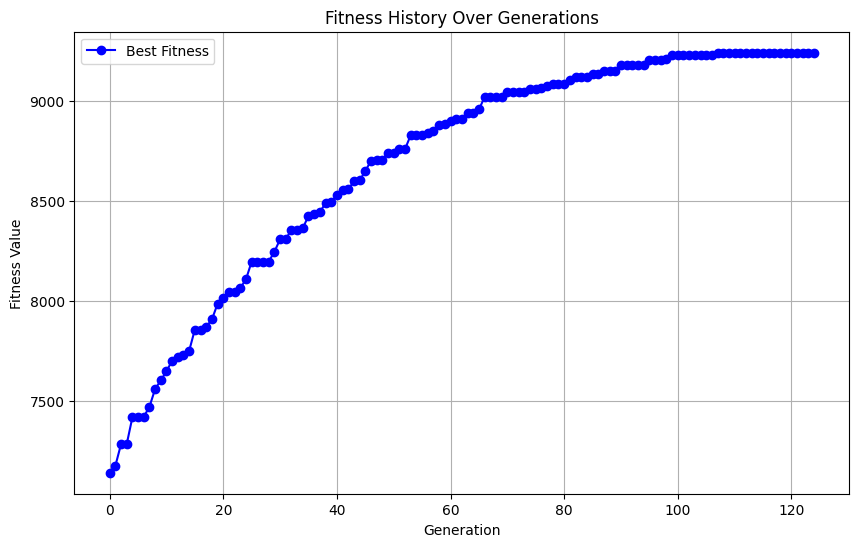

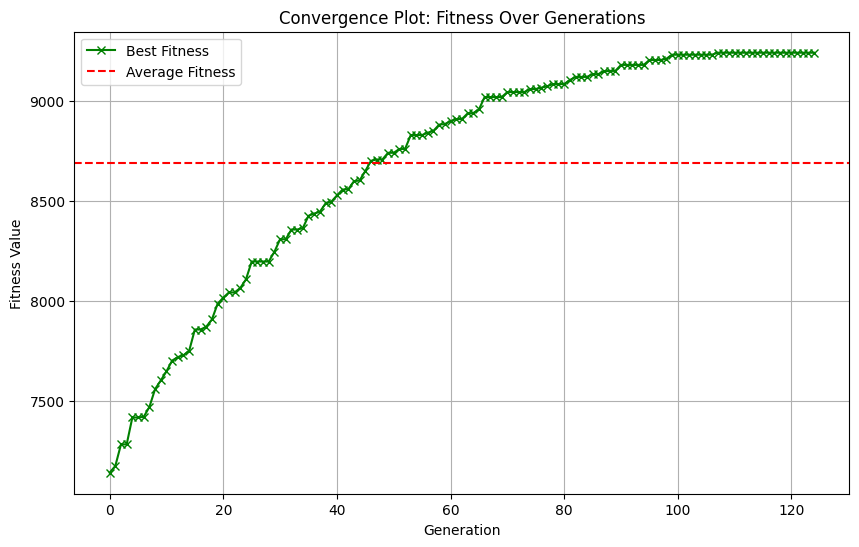

In [ ]:
# Assuming 'fitness_history' is already collected during the genetic algorithm run
# 1. Fitness History Plot
plt.figure(figsize=(10, 6))
plt.plot(fitness_history, label='Best Fitness', color='b', marker='o')
plt.title('Fitness History Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.grid(True)
plt.legend()
plt.show()

# 2. Convergence Plot (average of best fitness over generations)
plt.figure(figsize=(10, 6))
average_fitness = np.mean(fitness_history)
plt.plot(np.arange(len(fitness_history)), fitness_history, label='Best Fitness', color='g', marker='x')
plt.axhline(y=average_fitness, color='r', linestyle='--', label='Average Fitness')
plt.title('Convergence Plot: Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.grid(True)
plt.legend()
plt.show()


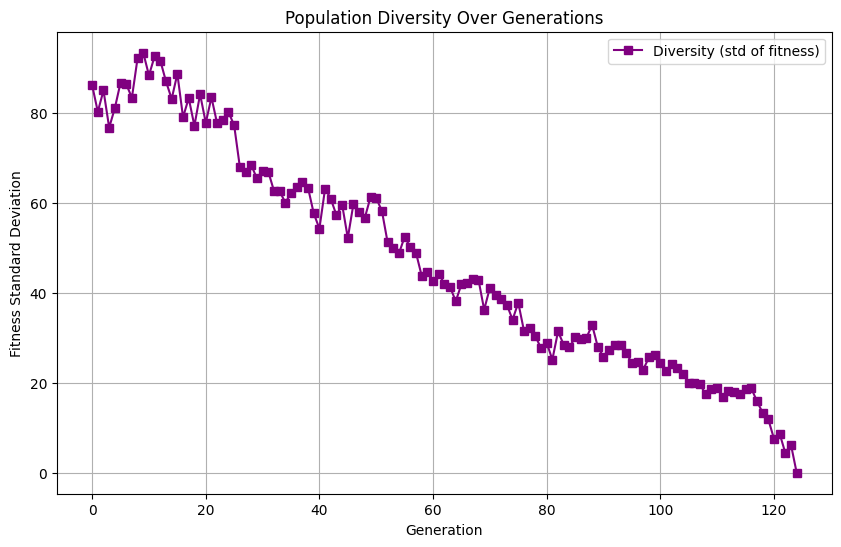

In [ ]:
# Assuming you store fitness values of all individuals per generation in a list called population_fitness_history

diversity = [np.std(gen_fitness) for gen_fitness in population_fitness_history]

plt.figure(figsize=(10, 6))
plt.plot(diversity, label='Diversity (std of fitness)', color='purple', marker='s')
plt.title('Population Diversity Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness Standard Deviation')
plt.grid(True)
plt.legend()
plt.show()


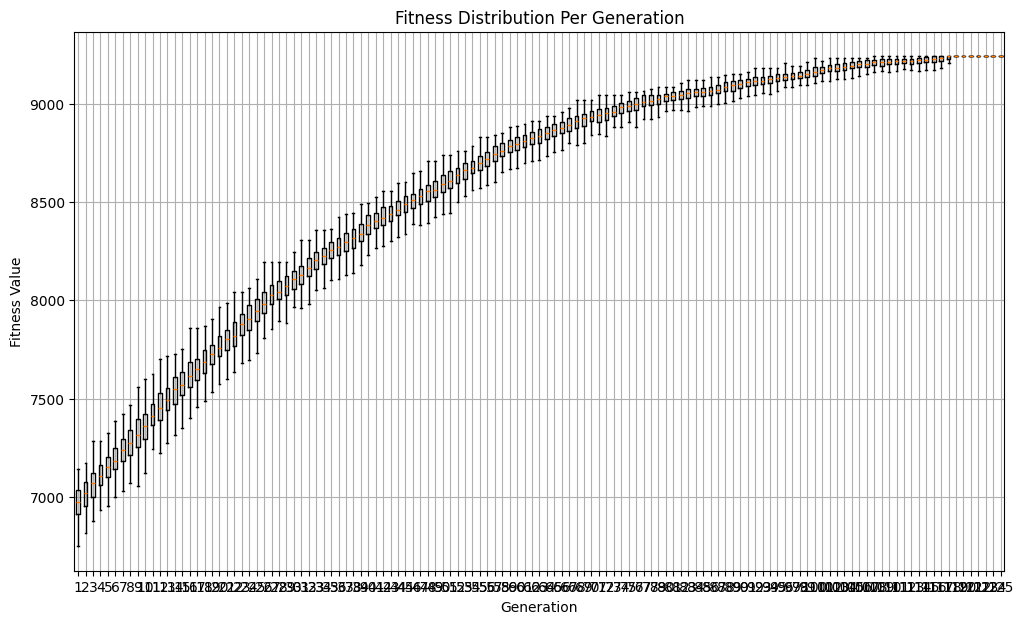

In [ ]:
# Again, assuming population_fitness_history is available

plt.figure(figsize=(12, 7))
plt.boxplot(population_fitness_history, showfliers=False)
plt.title('Fitness Distribution Per Generation')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.grid(True)
plt.show()


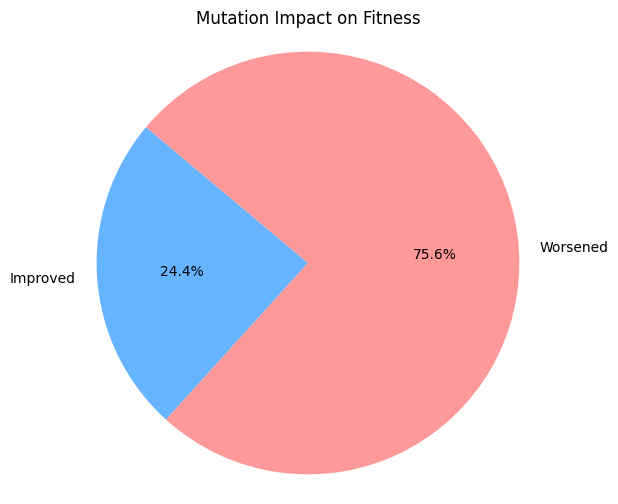

In [ ]:
# If you track per mutation whether fitness improved or not
# Suppose you have two lists: improvements and worsens

labels = ['Improved', 'Worsened']
values = [mutation_effectiveness_improvements, mutation_effectiveness_worsens]

plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title('Mutation Impact on Fitness')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()
